In [1]:
from facet_ml.classification import cnn
import torch
from torch import nn
import numpy as np
from torchvision.models import resnet152


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

# Load data
csv_path = r"C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\ProcessedData\Training_Data_20240216\2024_02_27_Rachel-C_Processed.csv"
h5_path = r"C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\ProcessedData\Training_Data_20240216\2024_02_16_Rachel-C_Training.h5"
dataloaders, datasizes = cnn.load_colloidal_datasets_h5(
    csv_file=csv_path,
    h5_file=h5_path,
    num_workers=4,
    batch_size=16,
    split_frac=0.7,
    stratify=True,
    three_class_mode=True,
)
check_input, check_output = next(iter(dataloaders["test"]))

c:\Users\Jacob\miniconda3\envs\colloidal_crystal_env\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


cuda


In [2]:
# from facet_ml.classification import cnn
# import torch
# from torch import nn
# import numpy as np
# from torchvision.models import resnet152


# # train on the GPU or on the CPU, if a GPU is not available
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(device)

# # Load data
# csv_path = r"C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\ProcessedData\Training_Data_20240216\2024_02_27_Rachel-C_Processed.csv"
# h5_path = r"C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\ProcessedData\Training_Data_20240216\2024_02_16_Rachel-C_Training.h5"
# dataloaders, datasizes = cnn.load_colloidal_datasets_h5(
#     csv_file=csv_path,
#     h5_file=h5_path,
#     num_workers=4,
#     batch_size=16,
#     split_frac=0.7,
#     stratify=True,
#     three_class_mode=True,
# )
# check_input, check_output = next(iter(dataloaders["test"]))

# print(check_input.shape, check_output.shape)

# # Load model
# model = cnn.get_model(3, resnet152(weights="DEFAULT"))
# # model = cnn.UNet(3, 5)
# model.to(device=device)

# ## Get model trianing information
# criterion = nn.CrossEntropyLoss()

# # construct an optimizer
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(
#     params, lr=0.005, momentum=0.9, weight_decay=0.01  # 0.0001
# )

# # and a learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# model, loss_dict, accuracy_dict = cnn.train_model(
#     model,
#     criterion,
#     optimizer,
#     lr_scheduler,
#     num_epochs=10,
#     dataloaders=dataloaders,
#     dataset_sizes=datasizes,
# )

# # Make quick plot
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(ncols=2)
# for ii, key in enumerate(loss_dict.keys()):
#     # ax = axes[ii]
#     x = np.array(range(len(loss_dict[key])))

#     for ii, (label, dict_oi) in enumerate(
#         [("Loss", loss_dict), ("Accuracy", accuracy_dict)]
#     ):
#         ax = axes[ii]
#         y = np.array(dict_oi[key])

#         ax.plot(x, y, label=f"{label}: {key}")
#         ax.legend()

# fig.savefig("Model_performance.png")
# torch.save(model.state_dict(), "resnet152_trained_dict.pth")
# torch.save(model, "resnet152_trained.pth")



In [3]:
from tempfile import TemporaryDirectory
import time
import os

def debug_train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    num_epochs,
    dataloaders: dict,
    dataset_sizes: dict,
):
    """
    Train num_epochs
    """
    since = time.time()

    # Create a temporary directory to save training checkpoints
    loss_dict = {"train": [], "test": []}
    accuracy_dict = {"train": [], "test": []}
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # Each epoch has a training and validation phase
            for phase in ["train", "test"]:
                regions = []
                actual = []
                logits = []
                results = []
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    regions.append(inputs)
                    actual.append(labels)
                    # inputs = torch.tensor(inputs)
                    # labels = torch.tensor(labels)
                    # print(inputs.shape, labels.shape)
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        preds = torch.argmax(outputs, 1)
                        logits.append(outputs)
                        results.append(preds)
                        # print("Outputs and Preds", outputs.shape, preds.shape)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == "train":
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = (running_corrects.double() / dataset_sizes[phase]).cpu()

                loss_dict[phase].append(epoch_loss)
                accuracy_dict[phase].append(epoch_acc)

                print(
                    f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}, ({running_corrects}/{dataset_sizes[phase]})"
                )

                # deep copy the model
                if phase == "test" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        print(f"Best val Acc: {best_acc:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path)) # Is this bugged?
    return model, loss_dict, accuracy_dict, regions, actual, logits, results

Epoch 0/49
----------
train Loss: 0.7031 Acc: 0.6975, (1137/1630)
test Loss: 0.5618 Acc: 0.7721, (315/408)

Epoch 1/49
----------
train Loss: 0.4862 Acc: 0.7957, (1297/1630)
test Loss: 0.5338 Acc: 0.7770, (317/408)

Epoch 2/49
----------
train Loss: 0.4346 Acc: 0.8110, (1322/1630)
test Loss: 0.4107 Acc: 0.8309, (339/408)

Epoch 3/49
----------
train Loss: 0.3498 Acc: 0.8503, (1386/1630)
test Loss: 0.3935 Acc: 0.8235, (336/408)

Epoch 4/49
----------
train Loss: 0.3440 Acc: 0.8564, (1396/1630)
test Loss: 0.3795 Acc: 0.8309, (339/408)

Epoch 5/49
----------
train Loss: 0.3321 Acc: 0.8638, (1408/1630)
test Loss: 0.3817 Acc: 0.8309, (339/408)

Epoch 6/49
----------
train Loss: 0.3152 Acc: 0.8613, (1404/1630)
test Loss: 0.3753 Acc: 0.8407, (343/408)

Epoch 7/49
----------
train Loss: 0.3307 Acc: 0.8558, (1395/1630)
test Loss: 0.3754 Acc: 0.8358, (341/408)

Epoch 8/49
----------
train Loss: 0.3132 Acc: 0.8607, (1403/1630)
test Loss: 0.3775 Acc: 0.8333, (340/408)

Epoch 9/49
----------
train 

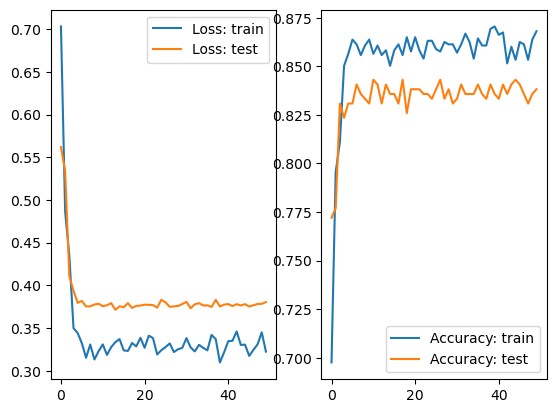

In [4]:
# Load model
model = cnn.get_model(3, resnet152(weights="DEFAULT"))
# model = cnn.UNet(3, 5)
model.to(device=device)

## Get model trianing information
criterion = nn.CrossEntropyLoss()

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, lr=0.005, momentum=0.9, weight_decay= 0.0001#0.01  # 0.0001
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model, loss_dict, accuracy_dict, regions, actual, logits, results=debug_train_model(
    model,
    criterion,
    optimizer,
    lr_scheduler,
    num_epochs=50,
    dataloaders=dataloaders,
    dataset_sizes=datasizes,
)
# Make quick plot
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2)
for ii, key in enumerate(loss_dict.keys()):
    # ax = axes[ii]
    x = np.array(range(len(loss_dict[key])))

    for ii, (label, dict_oi) in enumerate(
        [("Loss", loss_dict), ("Accuracy", accuracy_dict)]
    ):
        ax = axes[ii]
        y = np.array(dict_oi[key])

        ax.plot(x, y, label=f"{label}: {key}")
        ax.legend()


torch.save(model.state_dict(), "resnet152_trained_dict.pth")
torch.save(model, "resnet152_trained.pth")

In [5]:
# regions, actual, logits, results
print(list(zip(actual,results,logits)))
new_logits = model(regions[0].to("cuda")).to("cpu")

[(tensor([0, 2, 1, 0, 2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2]), tensor([0, 2, 1, 0, 2, 1, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2], device='cuda:0'), tensor([[ 2.0705e+00, -1.6542e+00, -5.9856e-01],
        [-1.0809e+00, -1.1940e+00,  1.9511e+00],
        [-2.6391e+00,  4.1462e+00, -1.7625e+00],
        [ 1.9198e+00, -2.3980e+00,  2.6163e-01],
        [-2.3546e-04, -2.6783e+00,  2.4032e+00],
        [-1.4246e+00,  3.9644e+00, -2.7321e+00],
        [ 4.2481e-02, -3.3234e+00,  3.0240e+00],
        [ 2.9881e+00, -1.3784e+00, -1.8065e+00],
        [ 3.3484e+00, -2.3566e+00, -1.3343e+00],
        [ 5.1254e-01, -2.7261e+00,  2.0142e+00],
        [-8.9900e-01, -5.5923e-01,  1.3073e+00],
        [-2.1957e+00, -5.3806e-01,  2.3890e+00],
        [ 5.2149e-01, -1.9126e+00,  1.2443e+00],
        [-5.5016e-01, -2.8454e+00,  3.2644e+00],
        [ 6.0955e-01, -1.5432e+00,  6.6827e-01],
        [-2.3090e+00, -2.4784e+00,  4.6127e+00]], device='cuda:0')), (tensor([2, 0, 2, 0, 0, 2, 0, 1, 2, 2, 2, 0, 1, 1, 1, 2]), te

In [6]:
for pair in list(zip(logits, new_logits)):
    print(pair)

(tensor([[ 2.0705e+00, -1.6542e+00, -5.9856e-01],
        [-1.0809e+00, -1.1940e+00,  1.9511e+00],
        [-2.6391e+00,  4.1462e+00, -1.7625e+00],
        [ 1.9198e+00, -2.3980e+00,  2.6163e-01],
        [-2.3546e-04, -2.6783e+00,  2.4032e+00],
        [-1.4246e+00,  3.9644e+00, -2.7321e+00],
        [ 4.2481e-02, -3.3234e+00,  3.0240e+00],
        [ 2.9881e+00, -1.3784e+00, -1.8065e+00],
        [ 3.3484e+00, -2.3566e+00, -1.3343e+00],
        [ 5.1254e-01, -2.7261e+00,  2.0142e+00],
        [-8.9900e-01, -5.5923e-01,  1.3073e+00],
        [-2.1957e+00, -5.3806e-01,  2.3890e+00],
        [ 5.2149e-01, -1.9126e+00,  1.2443e+00],
        [-5.5016e-01, -2.8454e+00,  3.2644e+00],
        [ 6.0955e-01, -1.5432e+00,  6.6827e-01],
        [-2.3090e+00, -2.4784e+00,  4.6127e+00]], device='cuda:0'), tensor([ 2.1926, -1.7120, -0.6200], grad_fn=<UnbindBackward0>))
(tensor([[-2.8716,  2.4938,  0.1399],
        [ 2.8955, -2.2270, -0.7880],
        [-2.1433, -2.4363,  4.5472],
        [ 1.2869, -2

In [7]:
for pair in list(zip(logits[0], new_logits)):
    print(pair)

(tensor([ 2.0705, -1.6542, -0.5986], device='cuda:0'), tensor([ 2.1926, -1.7120, -0.6200], grad_fn=<UnbindBackward0>))
(tensor([-1.0809, -1.1940,  1.9511], device='cuda:0'), tensor([-0.9082, -1.2488,  1.8735], grad_fn=<UnbindBackward0>))
(tensor([-2.6391,  4.1462, -1.7625], device='cuda:0'), tensor([-2.5232,  4.1233, -1.8212], grad_fn=<UnbindBackward0>))
(tensor([ 1.9198, -2.3980,  0.2616], device='cuda:0'), tensor([ 2.2564, -2.6019,  0.2166], grad_fn=<UnbindBackward0>))
(tensor([-2.3546e-04, -2.6783e+00,  2.4032e+00], device='cuda:0'), tensor([ 0.1253, -2.7792,  2.3999], grad_fn=<UnbindBackward0>))
(tensor([-1.4246,  3.9644, -2.7321], device='cuda:0'), tensor([-1.1903,  3.7492, -2.7526], grad_fn=<UnbindBackward0>))
(tensor([ 0.0425, -3.3234,  3.0240], device='cuda:0'), tensor([ 0.3164, -3.4404,  2.9268], grad_fn=<UnbindBackward0>))
(tensor([ 2.9881, -1.3784, -1.8065], device='cuda:0'), tensor([ 3.1702, -1.5754, -1.7699], grad_fn=<UnbindBackward0>))
(tensor([ 3.3484, -2.3566, -1.3343],

In [8]:

### DEBUGGING OUTPUTS

raw_results = []
cnn_results = []
actual = []
actual_from_row = []
region_list = []
adjusted_region_list = []
scores = []
accuracy_list = []
model.eval()
for inputs, labels in dataloaders["test"]:
    print(inputs.shape,labels.shape)
    actual.append(labels)

    # CNN application
    with torch.no_grad():
        inputs = inputs.to("cuda")
        cnn_output = model(inputs)
        raw = cnn_output.cpu()
        res = np.argmax(cnn_output.cpu(),axis=1)
        raw_results.append(raw)
        cnn_results.append(res)  # Move to CPU
    from sklearn.metrics import f1_score

    print(np.shape(res))
    accuracy_list.append((res == labels).sum()/len(inputs))
    scores.append(f1_score(labels, res,average="macro"))

    # Clean up to prevent memory issues
    del inputs, cnn_output
    torch.cuda.empty_cache()


torch.Size([16, 3, 256, 256]) torch.Size([16])
torch.Size([16])
torch.Size([16, 3, 256, 256]) torch.Size([16])
torch.Size([16])
torch.Size([16, 3, 256, 256]) torch.Size([16])
torch.Size([16])
torch.Size([16, 3, 256, 256]) torch.Size([16])
torch.Size([16])
torch.Size([16, 3, 256, 256]) torch.Size([16])
torch.Size([16])
torch.Size([16, 3, 256, 256]) torch.Size([16])
torch.Size([16])
torch.Size([16, 3, 256, 256]) torch.Size([16])
torch.Size([16])
torch.Size([16, 3, 256, 256]) torch.Size([16])
torch.Size([16])
torch.Size([16, 3, 256, 256]) torch.Size([16])
torch.Size([16])
torch.Size([16, 3, 256, 256]) torch.Size([16])
torch.Size([16])
torch.Size([16, 3, 256, 256]) torch.Size([16])
torch.Size([16])
torch.Size([16, 3, 256, 256]) torch.Size([16])
torch.Size([16])
torch.Size([16, 3, 256, 256]) torch.Size([16])
torch.Size([16])
torch.Size([16, 3, 256, 256]) torch.Size([16])
torch.Size([16])
torch.Size([16, 3, 256, 256]) torch.Size([16])
torch.Size([16])
torch.Size([16, 3, 256, 256]) torch.Size

In [9]:
scores
np.mean(accuracy_list)

0.8389423

In [10]:
ii = 8
list(zip(actual[ii],cnn_results[ii],raw_results[ii]))

[(tensor(2), tensor(2), tensor([-2.5321, -2.6168,  5.0928])),
 (tensor(2), tensor(2), tensor([-1.9906, -2.1874,  3.9690])),
 (tensor(1), tensor(1), tensor([-3.0041,  3.4846, -0.7822])),
 (tensor(2), tensor(2), tensor([-1.7860, -2.1418,  4.1715])),
 (tensor(2), tensor(2), tensor([ 0.6177, -1.5572,  0.7871])),
 (tensor(2), tensor(2), tensor([-0.3396, -1.4791,  1.8572])),
 (tensor(2), tensor(2), tensor([-0.7237, -2.5830,  3.1219])),
 (tensor(2), tensor(2), tensor([-3.6479,  1.5708,  1.7080])),
 (tensor(2), tensor(2), tensor([-1.0725, -1.5667,  2.3737])),
 (tensor(1), tensor(1), tensor([-2.7031,  3.2438, -0.9288])),
 (tensor(2), tensor(2), tensor([-2.1727, -2.1328,  4.1297])),
 (tensor(0), tensor(0), tensor([ 2.0554, -2.3855,  0.1336])),
 (tensor(2), tensor(2), tensor([ 1.0870, -3.1158,  1.9224])),
 (tensor(2), tensor(2), tensor([-1.6387, -1.5310,  3.1201])),
 (tensor(2), tensor(2), tensor([-2.2154, -3.0178,  5.3098])),
 (tensor(1), tensor(1), tensor([-3.4472,  3.3917, -0.3568]))]